# Figure 2 Final

Notebook to make figure 2 for ms <br>
by Cascade Tuholske 2020.02.23

In [ ]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import fmin
from scipy.stats import beta
from scipy.special import gamma as gammaf
import scipy


In [2]:
#### Functions
def OLS(df, geog, col, alpha):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography
    
    
    Args:
        df = HI stats dataframe
        geog = subset geography to calc people days regression
        col = col to regress on 
        alpha = ci alpha for coef 
    """

    # Get results
    labels = []
    #delt_list = [] #CPT 2020.02.26
    #r2_list = [] #CPT 2020.02.26
    coef_list = []
    leftci_list = []
    rightci_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[col].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        #r2 = model.rsquared_adj #CPT 2020.02.26
        p = model.pvalues[0]

        # Pop change #CPT 2020.02.26
#         delt = df_geog.drop_duplicates('ID_HDC_G0').copy()
#         delt['delt_pop'] = delt['P2016'] - delt['P1983']
#         delt = delt['delt_pop'].sum()

        # GET Left and Right CI
        left_ci = model.conf_int(alpha=alpha)[1][0]
        right_ci = model.conf_int(alpha=alpha)[1][1]
        
        # Make lists
        labels.append(label)
        #r2_list.append(r2) #CPT 2020.02.26
        coef_list.append(coef)
        p_list.append(p)
        leftci_list.append(left_ci)
        rightci_list.append(right_ci)
        #delt_list.append(delt) #CPT 2020.02.26

    # Make data frame
    df_out[geog] = labels
    #df_out['p_delt'] = delt_list #CPT 2020.02.26
    #df_out['r2'] = r2_list #CPT 2020.02.26
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]
    df_out['ci_left'] = leftci_list
    df_out['ci_right'] = rightci_list 

    return df_out


In [3]:
def run_OLS(stats, geog, alpha):
    """ Function calculate OLS coef of people days due to pop and heat and the 
    attribution index for distribution plots
    
    Args:
        stats = df to feed in
        geog = geography level to conduct analysis (city-level is 'ID-HDC-G0')
        alpha = alpha for CI coef 
    
    """
    # Get coef for people days
    out = OLS(stats, geog, 'people_days', alpha = alpha)
    out.rename(columns={"coef": "coef_pdays"}, inplace = True)
    out.rename(columns={"p_value": "p_value_pdays"}, inplace = True)
    out.rename(columns={"ci_left": "ci_left_pdays"}, inplace = True)
    out.rename(columns={"ci_right": "ci_right_pdays"}, inplace = True)
    
    # Get people days due to heat coef
    heat = OLS(stats, geog, 'people_days_heat', alpha = alpha) # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    heat.rename(columns={"p_value": "p_value_heat"}, inplace = True)
    heat.rename(columns={"ci_left": "ci_left_heat"}, inplace = True)
    heat.rename(columns={"ci_right": "ci_right_heat"}, inplace = True)
    out = out.merge(heat, on = geog, how = 'left') # merge
    
    # Get people days due to pop
    pop = OLS(stats, geog, 'people_days_pop', alpha = alpha) # get stats 
    pop.rename(columns={"coef": "coef_pop"}, inplace = True)
    pop.rename(columns={"p_value": "p_value_pop"}, inplace = True)
    pop.rename(columns={"ci_left": "ci_left_pop"}, inplace = True)
    pop.rename(columns={"ci_right": "ci_right_pop"}, inplace = True)
    out = out.merge(pop, on = geog, how = 'left') # merge
    
    # Get total days
    totDays = OLS(stats, geog, 'total_days', alpha = alpha) # get stats 
    totDays.rename(columns={"coef": "coef_totDays"}, inplace = True)
    totDays.rename(columns={"p_value": "p_value_totDays"}, inplace = True)
    totDays.rename(columns={"ci_left": "ci_left_totDays"}, inplace = True)
    totDays.rename(columns={"ci_right": "ci_right_totDays"}, inplace = True)
    out = out.merge(totDays, on = geog, how = 'left') # merge
    
    # attrib coef --- creates range -1 to 1 index of heat vs. population as a driver of total pdays increase
    out['coef_attrib'] = (out['coef_pop'] - out['coef_heat']) / (out['coef_pop'] + out['coef_heat']) # normalize dif
    out['coef_attrib_left'] = (out['ci_left_pop'] - out['ci_left_heat']) / (out['ci_left_pop'] + out['ci_left_heat']) # normalize dif
    out['coef_attrib_right'] = (out['ci_right_pop'] - out['ci_right_heat']) / (out['ci_right_pop'] + out['ci_left_heat']) # normalize dif
    
    # drop all neg or zero pday slopes
    out = out[out['coef_pdays'] > 0]
    out = out[out['coef_heat'] > 0]
    out = out[out['coef_pop'] > 0]
    
    # normalize coef of attribution 
    norm = out['coef_attrib']
    out['coef_attrib_norm'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_left']
    out['coef_attrib_norm_left'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_right']
    out['coef_attrib_norm_right'] = (norm-min(norm))/(max(norm)-min(norm))
    
    return out

In [4]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_IN = 'processed/All_data_HI406_figdata.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# scale the date in the plot 
scale = 10**9 

In [5]:
HI_STATS.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0
1,1,26,1983,1,194088.886834,194088.886834,268055.635628,0.000194,0.000194,0.0
2,2,27,1983,1,80540.779940,80540.779940,93335.494324,0.000081,0.000081,0.0
3,3,28,1983,9,59320.971209,59320.971209,91449.606255,0.000534,0.000534,0.0
4,4,29,1983,8,336518.836621,336518.836621,533318.453653,0.002692,0.002692,0.0


In [6]:
# cols we want to add to HI_STATS
cols = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0'] 

# open all the data
meta_fn = 'processed/All_data_HI406_meta.csv' # open all the data
all_data = pd.read_csv(DATA_IN+meta_fn)

# drop ID duplicates
meta = all_data.drop_duplicates('ID_HDC_G0')
meta = meta[cols]

In [7]:
print(len(all_data))
print(len(all_data.drop_duplicates('ID_HDC_G0')))
print(len(HI_STATS))
print(len(meta))

5616932
11558
392972
11558


In [8]:
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'inner')
HI_STATS.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop,region,intermediate-region,sub-region,CTR_MN_NM
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.000000,Americas,Northern America,Northern America,United States
1,10112,22,1984,1,53373.163358,52064.452435,73006.671133,0.000053,0.000052,0.000001,Americas,Northern America,Northern America,United States
2,48718,22,1988,10,58608.007050,52064.452435,73006.671133,0.000586,0.000521,0.000065,Americas,Northern America,Northern America,United States
3,58884,22,1989,1,59916.717973,52064.452435,73006.671133,0.000060,0.000052,0.000008,Americas,Northern America,Northern America,United States
4,68579,22,1990,6,61225.428896,52064.452435,73006.671133,0.000367,0.000312,0.000055,Americas,Northern America,Northern America,United States


In [9]:
len(HI_STATS)

392972

# Beta Fits

In [39]:
# https://stackoverflow.com/questions/23329331/how-to-properly-fit-a-beta-distribution-in-python
# https://stats.stackexchange.com/questions/414277/fitting-beta-distributions-to-data

#### Chunk 1
geog1 = 'sub-region'
loc1 = 'Sub-Saharan Africa'
chunk1 = HI_STATS[HI_STATS[geog1] == loc1]
plotdata1 = run_OLS(chunk1, 'ID_HDC_G0', alpha = 0.05)


#### Chunk 2
geog2 = 'sub-region'
loc2 = 'Northern America'
chunk2 = HI_STATS[HI_STATS[geog2] == loc2]
plotdata2 = run_OLS(chunk2, 'ID_HDC_G0', alpha = 0.05)


#### Chunk 3
geog3 = 'region'
loc3 = 'Europe'
chunk3 = HI_STATS[HI_STATS[geog3] == loc3]
plotdata3 = run_OLS(chunk3, 'ID_HDC_G0', alpha = 0.05)

In [33]:
def beta_fit(data):
 
    #### Fit Data
    alpha3,beta3,xx,yy=beta.fit(data, loc = 0, scale = 1)
    fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

    xx=np.linspace(0,max(data),len(data)) # line space of X
    xx = xx[1:] # drop first value of zero because it makes plot look funky
    yy = fitted(xx,alpha3,beta3) # fit values to beta pdf function
    
    return xx, yy

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


Text(0.5, 1.0, 'Dist of PeopleDays Attribution Coef, 1983 - 2016')

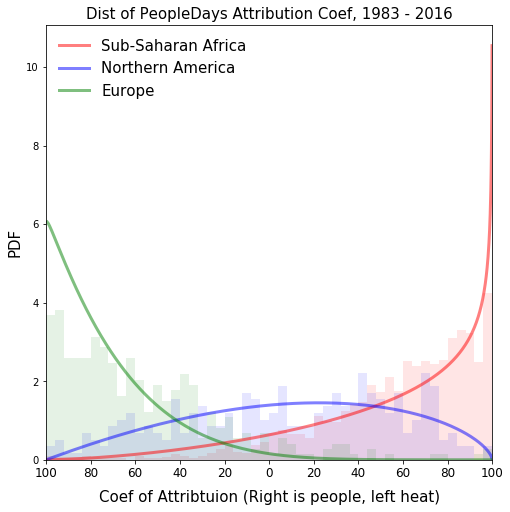

In [99]:
#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

kwargs = {'lw': 3, 'alpha' : 0.5, 'linestyle' : '-'}

#### Chunk 1
data = plotdata1['coef_attrib_norm']
X, Y = beta_fit(data)
plt.hist(data, density = True, color = 'r', alpha = 0.1, bins = 50)
plt.plot(X, Y, label = loc1, color = 'r', **kwargs)

# #### Chunk 2
data = plotdata2['coef_attrib_norm']
X, Y = beta_fit(data)
plt.hist(data, density = True, color = 'b', alpha = 0.1, bins = 50)
plt.plot(X, Y, label = loc2, color = 'b', **kwargs)

#### Chunk 3
data = plotdata3['coef_attrib_norm']
X, Y = beta_fit(data)
plt.hist(data, density = True, color = 'g', alpha = 0.1, bins = 50)
plt.plot(X, Y, label = loc3, color = 'g', **kwargs)


#### Lims and Ticks
plt.xlim([0,1])
ticks = [x / 10 for x in list(range(0,11))]
labels = [100, 80, 60, 40, 20, 0, 20, 40, 60, 80, 100]
plt.xticks(ticks, labels, fontsize = 12)

#### Legends
labels = [loc1, loc2, loc3]
plt.legend(labels, loc=2, facecolor= 'white', edgecolor = 'white', fontsize = 15)


## Labels 
plt.xlabel('Coef of Attribtuion (Right is people, left heat)', fontsize = 15, labelpad = 10)
plt.ylabel('PDF', fontsize = 15)
plt.title('Dist of PeopleDays Attribution Coef, 1983 - 2016', fontsize = 15)


In [81]:
[x / 10 for x in list(range(0,10))]

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]
/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


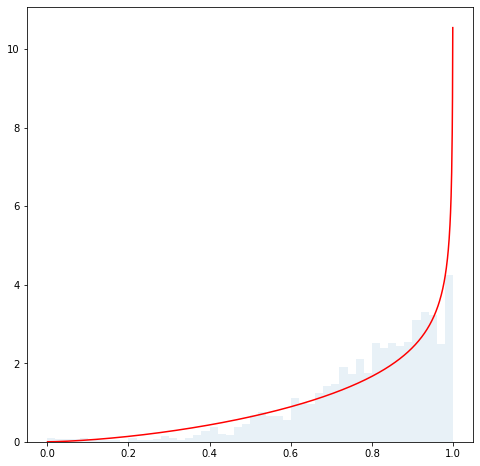

In [26]:
#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

##################### MIDDLE #####################
#### Get data to plot
data = plotdata1['coef_attrib_norm'] 

#### Fit Data
alpha3,beta3,xx,yy=beta.fit(data, loc = 0, scale = 1)

#### Plot Data
plt.hist(data,bins=50,normed=True, alpha = 0.1)
fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

xx=np.linspace(0,max(data),len(data))
xx = xx[1:] # drop zero
plt.plot(xx,fitted(xx,alpha3,beta3),'r')

In [ ]:
#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

##################### MIDDLE #####################
#### Get data to plot
data = plotdata['coef_attrib_norm'] 

#### Fit Data
alpha3,beta3,xx,yy=beta.fit(data, loc = 0, scale = 1)

#### Plot Data
plt.hist(data,bins=50,normed=True, alpha = 0.1)
fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

xx=np.linspace(0,max(data),len(data))
xx = xx[1:] # drop zero
plt.plot(xx,fitted(xx,alpha3,beta3),'r')

##################### Left #####################
#### Get data to plot
data = plotdata['coef_attrib_norm_left'] 

#### Fit Data
alpha3,beta3,xx,yy=beta.fit(data, loc = 0, scale = 1)

#### Plot Data
plt.hist(data,bins=50,normed=True, alpha = 0.1)
fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

xx=np.linspace(0,max(data),len(data))
xx = xx[1:] # drop zero
plt.plot(xx,fitted(xx,alpha3,beta3),'b')

##################### right #####################
#### Get data to plot
data = plotdata['coef_attrib_norm_right'] 

#### Fit Data
alpha3,beta3,xx,yy=beta.fit(data, loc = 0, scale = 1)

#### Plot Data
plt.hist(data,bins=50,normed=True,  alpha = 0.1)
fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

xx=np.linspace(0,max(data),len(data))
xx = xx[1:] # drop zero
plt.plot(xx,fitted(xx,alpha3,beta3),'g')


plt.xlim([0,1])
plt.ylim([0,10])

plt.title('Beta Fit for '+loc)
plt.show()

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.443e+03, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([-28.80462024, -22.55706412, -16.30950801, -10.06195189,
         -3.81439577,   2.43316034,   8.68071646,  14.92827257,
         21.17582869,  27.4233848 ,  33.67094092]),
 <a list of 10 Patch objects>)

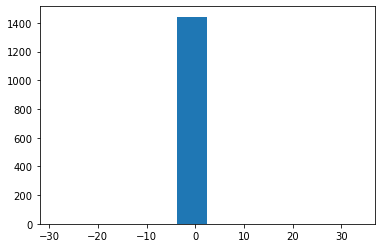

In [18]:
plt.hist(plotdata['coef_attrib_right'])

In [ ]:
#### Fit Data
alpha3,beta3,xx,yy=beta.fit(data, loc = 0, scale = 1)


In [ ]:
#### Plot Data
plt.hist(data,bins=50,normed=True)
fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

xx=np.linspace(0,max(data),len(data))
xx = xx[1:] # drop zero

plt.plot(xx,fitted(xx,alpha3,beta3),'r')
plt.xlim([0,1])
plt.ylim([0,10])

plt.title('Beta Fit for '+loc)
plt.show()

In [ ]:
plt.hist(data, weights=np.ones_like(data)/np.sum(data))

In [ ]:
plt.hist(data, weights=np.ones_like(data)/np.sum(data))
weights = np.ones_like(data)/np.sum(data)
weights = weights[1:]
yy = fitted(xx,alpha3,beta3) * 0.00131631
plt.plot(xx,yy,'r')

In [ ]:
plt.hist(data)

In [ ]:
xx=numpy.linspace(0,max(data),len(data))
xx

In [ ]:
#### Plot Data
weights = np.ones_like(data)/np.sum(data)
plt.hist(data, weights=weights)
fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta

xx=numpy.linspace(0,max(data),len(data))
xx = xx[1:] #* weights[1:] # drop zero 

plt.plot(xx,fitted(xx,alpha3,beta3),'r')
plt.xlim([0,1])
plt.ylim([0,5])

plt.title('Beta Fit for '+loc)
plt.show()

# Fig 2 Scatter

In [ ]:
#### Find Regions where the trend in people days is sig at 0.05

# Args
heat_stat = 'total_days'
pdays_stat = 'people_days'
geog = 'sub-region'

# Find Sig Regions
df_region = pop_stat(stats, geog, heat_stat)
df_region = df_region[df_region['p_value'] < 0.05]

# Get the regions in a list and re-order 
sig_regions = list(df_region[geog])
sig_regions = [sig_regions[10], sig_regions[11],  sig_regions[4],
               sig_regions[6], sig_regions[1], sig_regions[9],
               sig_regions[7], sig_regions[8], sig_regions[5],
               sig_regions[0], sig_regions[3], sig_regions[2]]
len(sig_regions)

In [ ]:
#### Or use All regions --- Reorder if needed
sig_regions = ['Australia and New Zealand',
 'Central Asia',
 'Eastern Asia',
 'Eastern Europe',
 'Latin America and the Caribbean',
 'Melanesia',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'South-eastern Asia',
 'Southern Asia',
 'Southern Europe',
 'Sub-Saharan Africa',
 'Western Asia',
 'Western Europe']

In [ ]:
#### Plot and Save Figure 
#### Plot is people-days heat vs pop increase in log scale values
fig, axs = plt.subplots(5, 3, figsize = (15, 15), sharex=True) # Change number of panels as needed
axs = axs.ravel()
counter = 0
lim = 13

for i, region in enumerate(sig_regions):
    
    df_region = stats[stats[geog] == region] # select region
    
    # Get people days dues to heat coef
    heat = pop_stat(df_region, 'ID_HDC_G0', 'people_days_heat') # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    
    # Get people days total
    pdays_all = pop_stat(df_region, 'ID_HDC_G0', 'people_days_pop') # get stats
    pdays_all.rename(columns={"coef": "coef_pop"}, inplace = True)
    
    # Merge pdays_all and heat
    heat = heat.merge(pdays_all[['ID_HDC_G0', 'coef_pop']], on = 'ID_HDC_G0', how = 'left')
    
    # drop negitive and zero slopes
    heat = heat[heat['coef_heat'] > 0]
    heat = heat[heat['coef_pop'] > 0]
    
    # get data for plot
    X = np.log10(heat['coef_pop']*scale)
    Y = np.log10(heat['coef_heat']*scale)
    C = np.log10(heat['p_delt'])
    
    # drop all slopes below 10^0
    X = X * (X > 0)
    Y = Y * (Y > 0)
    
    # plots
    a = i + counter
    im  = axs[a].scatter(X, Y, alpha = 0.4, marker = 'h', c = C, cmap = 'rainbow')
    axs[a].set_title(region, fontsize = 14)
    
    # Set limits
    axs[a].set_xlim([-0.5, lim])
    axs[a].set_ylim([-0.5, lim])
    
    # Make one-to-one-line
    axs[a].plot([0, lim], [0, lim], ':', lw=3, alpha = 0.7, color = 'black')
    
    fig.colorbar(ax = axs[a], mappable = im)

fig.text(0.5, 0.08, 'Annual increase in people-days [log10] due to population', ha='center', size = 16)
fig.text(0.07, 0.5, 'Annual increase in people-days [log10] due to heat', va='center', rotation='vertical',
        size = 16)

#plt.savefig(FIG_OUT+'FIG2.png') 

# Fig 2 Dist

In [ ]:
def plot_data(stats, geog):
    """ Function calculate coef of people days due to pop and heat and the 
    attribution index
    
    Args:
        stats = df to feed in
        geog = geography level to conduct analysis (city-level is 'ID-HDC-G0')
    
    """
    # Get people days dues to heat coef
    heat = pop_stat(stats, geog, 'people_days_heat') # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    
    # Get people days total
    pdays_all = pop_stat(stats, geog, 'people_days_pop') # get stats
    pdays_all.rename(columns={"coef": "coef_pop"}, inplace = True)
    
    # Merge pdays_all and heat
    heat = heat.merge(pdays_all[[geog, 'coef_pop']], on = geog, how = 'left')
    
    # drop negitive and zero slopes
    heat = heat[heat['coef_heat'] > 0]
    heat = heat[heat['coef_pop'] > 0]
    
    # attrib coef
    heat['coef_attrib'] = (heat['coef_pop'] - heat['coef_heat']) / (heat['coef_pop'] + heat['coef_heat']) # normalize dif
    
    return heat

In [ ]:
#### Chunk Data
geog = 'sub-region'
loc = 'Northern America'
chunk_stats = stats[stats[geog] == loc]

Y95= chunk_stats[(chunk_stats['year'] >= 1986) & (chunk_stats['year'] <= 1995)]
Y05 = chunk_stats[(chunk_stats['year'] >= 1996) & (chunk_stats['year'] <= 2005)]
Y15 = chunk_stats[(chunk_stats['year'] >= 2006) & (chunk_stats['year'] <= 2015)]

In [ ]:
#### Make distribution

Y95_plotdata = plot_data(Y95, 'ID_HDC_G0')
Y95_plotdata.head()

Y05_plotdata = plot_data(Y05, 'ID_HDC_G0')
Y95_plotdata.head()

Y15_plotdata = plot_data(Y15, 'ID_HDC_G0')
Y15_plotdata.head()

In [ ]:
data = Y15_plotdata['coef_attrib']
bins = 20
#plt.hist(data, color = 'blue', alpha = 0.3, bins = bins)
#sns.kdeplot(np.array(data), bw=0.15, color = 'blue', alpha = 0.4)

data = Y05_plotdata['coef_attrib']
#plt.hist(data, color = 'green', alpha = 0.3, bins = bins)
#sns.kdeplot(np.array(data), bw=0.15, color = 'green', alpha = 0.4)

data = Y95_plotdata['coef_attrib']
plt.hist(data, color = 'red', alpha = 0.3, bins = bins)
#sns.kdeplot(np.array(data), bw=0.15, color = 'red', alpha = 0.4)
plt.xlabel('Coef of Attribtuion (Right is people, left heat)')
plt.ylabel('N of Cites')
plt.title(loc+' Dist of PeopleDays Attribution Coef')
#sns.kdeplot(np.array(data), bw=0.5)

labels = ['1986 - 1995', '1996 - 2005', '2006 - 2015']
plt.legend(labels, loc=1, facecolor= 'white', edgecolor = 'white')


# Desnity Plots


### North America 

In [ ]:
#### Chunk Data
geog = 'region'
loc = 'Europe'
chunk_stats = stats[stats[geog] == loc]

Y95= chunk_stats[(chunk_stats['year'] >= 1986) & (chunk_stats['year'] <= 1995)]
Y05 = chunk_stats[(chunk_stats['year'] >= 1996) & (chunk_stats['year'] <= 2005)]
Y15 = chunk_stats[(chunk_stats['year'] >= 2006) & (chunk_stats['year'] <= 2015)]

#### Make distribution
all_plotdata = plot_data(chunk_stats, 'ID_HDC_G0')
Y95_plotdata = plot_data(Y95, 'ID_HDC_G0')
Y05_plotdata = plot_data(Y05, 'ID_HDC_G0')
Y15_plotdata = plot_data(Y15, 'ID_HDC_G0')

In [ ]:
bw = 'scott'
kws1 = {'bw': bw, 'linewidth': 0, 'shade': True, 'alpha' : 0.05}
kws2 = {'bw': bw, 'linewidth': 2, 'shade': False, 'alpha' : 0.5}

#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

data = all_plotdata['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'black', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'black', kde_kws= kws2, label = '1983 - 2016')

data = Y15_plotdata['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'darkblue', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'darkblue', kde_kws= kws2, label = '2006 - 2015')


data = Y05_plotdata['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'red', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'red', kde_kws= kws2, label = '1996 - 2005')

data = Y95_plotdata['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'green', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'green', kde_kws= kws2, label = '1986 - 1995')


## Labels 
plt.xlabel('Coef of Attribtuion (Right is people, left heat)')
plt.ylabel('Density')
plt.title(loc+' Dist of PeopleDays Attribution Coef')

## Legend
#labels = ['1986 - 1995', '1996 - 2005', '2006 - 2015']
plt.legend(loc=2, facecolor= 'white', edgecolor = 'white')

### SS Africa

In [ ]:
#### Chunk Data
geog = 'sub-region'
loc = 'Sub-Saharan Africa'
chunk_stats = stats[stats[geog] == loc]

Y95= chunk_stats[(chunk_stats['year'] >= 1986) & (chunk_stats['year'] <= 1995)]
Y05 = chunk_stats[(chunk_stats['year'] >= 1996) & (chunk_stats['year'] <= 2005)]
Y15 = chunk_stats[(chunk_stats['year'] >= 2006) & (chunk_stats['year'] <= 2015)]

#### Make distribution
Y95_plotdata = plot_data(Y95, 'ID_HDC_G0')
Y05_plotdata = plot_data(Y05, 'ID_HDC_G0')
Y15_plotdata = plot_data(Y15, 'ID_HDC_G0')

In [ ]:
bw = 'scott'
kws = {'bw': bw, 'linewidth': 1, 'alpha' : 0.5}

#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

data = Y15_plotdata['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'darkblue', kde_kws= kws, label = '2006 - 2015')

data = Y05_plotdata['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'red', kde_kws= kws, label = '1996 - 2005')

data = Y95_plotdata['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'green', kde_kws= kws, label = '1986 - 1995')

## Labels 
plt.xlabel('Coef of Attribtuion (Right is people, left heat)')
plt.ylabel('Density')
plt.title(loc+' Dist of PeopleDays Attribution Coef')

## Legend
#labels = ['1986 - 1995', '1996 - 2005', '2006 - 2015']
plt.legend(loc=2, facecolor= 'white', edgecolor = 'white')

## Plots of Different Regions

In [ ]:
#### Chunk SSA
geog = 'sub-region'
loc = 'Sub-Saharan Africa'
chunk_SSA = stats[stats[geog] == loc]
plotdata_SSA = plot_data(chunk_SSA, 'ID_HDC_G0')

#### Chunk SSA
geog = 'region'
loc = 'Europe'
chunk_EU = stats[stats[geog] == loc]
plotdata_EU = plot_data(chunk_EU, 'ID_HDC_G0')

#### Chunk North America
geog = 'sub-region'
loc = 'Northern America'
chunk_NA = stats[stats[geog] == loc]
plotdata_NA = plot_data(chunk_NA, 'ID_HDC_G0')

In [ ]:
bw = 'scott'
kws1 = {'bw': bw, 'linewidth': 0, 'shade': True, 'alpha' : 0.05}
kws2 = {'bw': bw, 'linewidth': 2, 'shade': False, 'alpha' : 0.5}

#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

data = plotdata_SSA['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'darkblue', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'darkblue', kde_kws= kws2, label = 'Sub-Saharan Africa')

data = plotdata_EU['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'red', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'red', kde_kws= kws2, label = 'Europe')

data = plotdata_NA['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'green', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'green', kde_kws= kws2, label = 'Northern America')


## Labels 
plt.xlabel('Coef of Attribtuion (Right is people, left heat) 1983 - 2016')
plt.ylabel('Density')
plt.title(loc+' Dist of PeopleDays Attribution Coef')

## Legend
#labels = ['1986 - 1995', '1996 - 2005', '2006 - 2015']
plt.legend(loc=2, facecolor= 'white', edgecolor = 'white')

In [ ]:
#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

data = plotdata_SSA['coef_attrib']
plt.hist(data, color = 'r', alpha = 0.5)

data = plotdata_EU['coef_attrib']
plt.hist(data, color = 'b', alpha = 0.5)

data = plotdata_NA['coef_attrib']
plt.hist(data, color = 'g', alpha = 0.5)


In [ ]:
#### Chunk SSA
geog = 'CTR_MN_NM'
loc1 = 'Saudi Arabia'
chunk_1 = stats[stats[geog] == loc1]
plotdata_1 = plot_data(chunk_1, 'ID_HDC_G0')

#### Chunk SSA
geog = 'CTR_MN_NM'
loc2 = 'Mexico'
chunk_2 = stats[stats[geog] == loc2]
plotdata_2 = plot_data(chunk_2, 'ID_HDC_G0')

#### Chunk North America
geog = 'CTR_MN_NM'
loc3 = 'China'
chunk_3 = stats[stats[geog] == loc3]
plotdata_3 = plot_data(chunk_3, 'ID_HDC_G0')

In [ ]:
bw = 'scott'
kws1 = {'bw': bw, 'linewidth': 0, 'shade': True, 'alpha' : 0.05}
kws2 = {'bw': bw, 'linewidth': 2, 'shade': False, 'alpha' : 0.5}

#### Size
fig = plt.gcf()
fig.set_size_inches(8, 8)

data = plotdata_1['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'darkblue', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'darkblue', kde_kws= kws2, label = loc1)

data = plotdata_2['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'red', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'red', kde_kws= kws2, label = loc2)

data = plotdata_3['coef_attrib']
sns.distplot(data, hist=False, kde=True, color = 'green', kde_kws= kws1)
sns.distplot(data, hist=False, kde=True, color = 'green', kde_kws= kws2, label = loc3)


## Labels 
plt.xlabel('Coef of Attribtuion (Right is people, left heat) 1983 - 2016')
plt.ylabel('Density')
plt.title(loc+' Dist of PeopleDays Attribution Coef')

## Legend
#labels = ['1986 - 1995', '1996 - 2005', '2006 - 2015']
plt.legend(loc=2, facecolor= 'white', edgecolor = 'white')

# Old OLS TEST

In [ ]:
#### Chunk SSA
geog = 'CTR_MN_NM'
loc = 'Iran'
chunk = HI_STATS[HI_STATS[geog] == loc]


In [ ]:
chunk.head()

In [ ]:
alpha = 0.05
test_ols = OLS_coef(chunk, geog = 'ID_HDC_G0', col = 'total_days', alpha = alpha)
test_ols = test_ols[test_ols['p_value'] < 0.05]
test_ols.head(1)

In [ ]:
# Get Data
df_geog =  HI_STATS[HI_STATS['ID_HDC_G0'] == 5368]
col = 'total_days'

X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(df_geog.groupby('year')[col].sum()).reshape((-1, 1))

# Add Intercept
X_year_2 = sm.add_constant(X_year)

# Regress
model = sm.OLS(Y_stats, X_year_2).fit() 

In [ ]:
print(model.conf_int(alpha=alpha)[1][0])
print(model.conf_int(alpha=alpha)[1][1])
print(round(model.params[1], 7))
print(model.rsquared_adj)

In [ ]:
model.summary()